# 10.3

## 10.3: Analysis of periodic time series

### 10.3.1: A single sinusoidal model
- We would like to investigate the possible periodicity of a signal, and if it is periodic, to estimate the period
- The signal may be buried in noise
- Simple model: single harmonic frequency with homoscedastic Gaussian errors parameterized by $\sigma$
$$y\left(t\right)=a \sin\left(\omega t\right)+b \cos\left(\omega t\right)+\epsilon$$

#### Generate measurement data from a single component signal overlayed with Gaussian noise

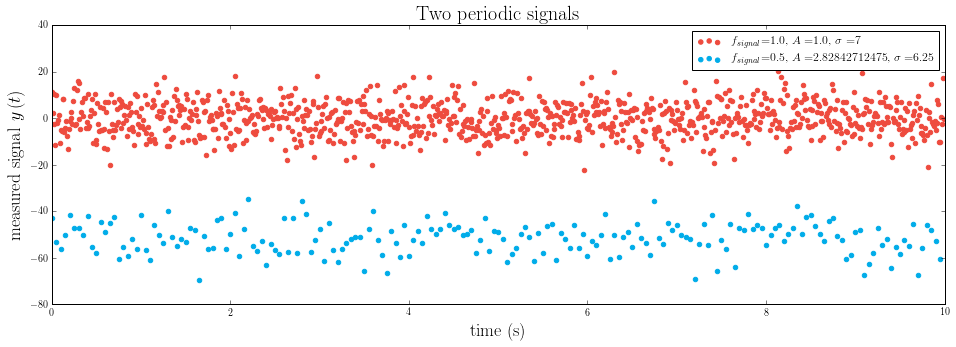

In [1]:
from scipy.stats import norm
from scipy.fftpack import fft, ifft
from math import sin, cos, exp, log
import random as ra
import matplotlib.pyplot as plt
%matplotlib inline

pi=3.14159

# Signal 0
N_0=1000
a_0=1.
b_0=0.
A_0=(a_0**2.+b_0**2.)**.5
sigma_0=7 #10, 8
dt_0=0.01
f_0=1.
omega_0=2.*pi*f_0

ts_0=[dt_0*i for i in range(N_0)]
ys_signal_0=[a_0*sin(omega_0*ts_0[i])+b_0*cos(omega_0*ts_0[i])for i in range(N_0)]
ys_noise_0=sigma_0*norm.rvs(size=N_0)
ys_measured_0=[ys_signal_0[i]+ys_noise_0[i] for i in range(N_0)]


# Signal 1
N_1=200
a_1=2.
b_1=2.
A_1=(a_1**2.+b_1**2.)**.5
sigma_1=6.25 #5, 6.5, 5.5
dt_1=0.05
f_1=.5
omega_1=2.*pi*f_1

ts_1=[dt_1*i for i in range(N_1)]
ys_signal_1=[a_1*sin(omega_1*ts_1[i])+b_1*cos(omega_1*ts_1[i])for i in range(N_1)]
ys_noise_1=sigma_1*norm.rvs(size=N_1)
ys_measured_1=[ys_signal_1[i]+ys_noise_1[i] for i in range(N_1)]


# Plot the measurements
fig=plt.figure()

c_0=(238/255.,75/255.,62/255.)
c_1=(0/255.,172/255.,233/255.)
plt.scatter(ts_0,ys_measured_0, label=r'$f_{signal}$='+str(f_0)+', $A=$'+str(A_0)+', $\sigma=$'+str(sigma_0), color=c_0)
plt.scatter(ts_1, [y-3.*(sigma_0+sigma_1+(a_0**2.+b_0**2.)**.5+(a_1**2.+b_1**2.)**.5) for y in ys_measured_1],\
         label=r'$f_{signal}$='+str(f_1)+', $A=$'+str(A_1)+', $\sigma=$'+str(sigma_1), color=c_1)

plt.legend()

plt.xlim(0,max(N_0*dt_0, N_1*dt_1))

title_size=20
label_size=18
legend_size=16
plt.title('Two periodic signals', size=title_size)
plt.xlabel('time (s)', size=label_size)
plt.ylabel(r'measured signal $y\left(t\right)$', size=label_size)

fig.set_size_inches(16,5)


plt.show()

- Write down the likelihood of the data:
$$L=p\left(\{t,y\}|\omega,a,b,\sigma\right)=\prod_{j=1}^{N}\frac{1}{\sqrt{2\pi}\sigma}\text{exp}\left(\frac{-\left[y_{j}-a\sin\left(\omega t_{j}\right)-b\cos\left(\omega t_{j}\right)\right]^{2}}{2\sigma^{2}}\right)$$

- Assume uniform priors for $a, b, \omega$ and $\sigma$. 
    - Assume $\omega$ and $\sigma$ must be positive (uninformative priors)
    
- Posterior pdf is 
$$p\left(\omega, a, b, \sigma |\{t,y\}\right)\propto\sigma^{-N}\text{exp}\left(\frac{-NQ}{2\sigma^{2}}\right)$$, where

$$Q=V-\frac{2}{N}\left[aI\left(\omega\right)+bR\left(\omega\right)-abM\left(\omega\right)-\frac{1}{2}a^{2}S\left(\omega\right)-\frac{1}{2}b^{2}C\left(\omega\right)\right]$$

$$V=\frac{1}{N}\sum_{j=1}^{N}y^{2}_{j}$$

$$I\left(\omega\right)=\sum_{j=1}^{N}y_{j}\sin\left(\omega t_{j}\right), R\left(\omega\right)=\sum_{j=1}^{N}y_{j}\cos\left(\omega t_{j}\right)$$

$$M\left(\omega\right)=\sum_{j=1}^{N}\sin\left(\omega t_{j}\right)\cos\left(\omega t_{j}\right)$$

$$S\left(\omega\right)=\sum_{j=1}^{N}\sin^{2}\left(\omega t_{j}\right), C\left(\omega\right)=\sum_{j=1}^{N}\cos^{2}\left(\omega t_{j}\right)$$

- If $N\gg 1$ and our measurements capture enough phase change in the latent signal ($\omega t_{N}\ll 1$), $Q$ can be simplified.

- To determine if signal is periodic, we only care about $\omega$, so we marginalize over the other model parameters $a$ and $b$

- The marginalized posterior becomes 

(known noise level $\sigma$
$$p\left(\omega |\{t,y\}, \sigma\right)\propto\text{exp}\left(\frac{P\left(\omega\right)}{\sigma^{2}}\right)$$

(unknown noise level $\sigma$; marginalize)
$$p\left(\omega |\{t,y\}\right)\propto\left[1-\frac{2P\left(\omega\right)}{NV}\right]^{1-N/2}$$

$P\left(\omega\right)$ is the **periodogram** given by
$$P\left(\omega\right)=\frac{1}{N}\left[I^{2}\left(\omega\right)+R^{2}\left(\omega\right)\right]$$

#### Let's plot the posterior distribution of $\omega$ 

In [2]:
def V(ys):
    V=1./len(ys)*sum(y**2. for y in ys)
    return V

def I(omega, t, ys):
    I=sum(ys[i]*sin(omega*t[i]) for i in range(len(ys)))
    return I

def R(omega, t, ys):
    R=sum(ys[i]*cos(omega*t[i]) for i in range(len(ys)))
    return R

def P(omega, t, ys):
    N=len(t)
    P=1./N*(I(omega, t, ys)**2.+R(omega, t, ys)**2.)
    return P

def p(omega, t, ys):
    N=len(t)
    p=(1-2*P(omega, t, ys)/(N*V(ys)))**(1-N/2)
    return p

def pnorm(omegas, t, ys):
    pnorm=0
    for omega in omegas:
        pnorm+=p(omega, t, ys)
    return pnorm

def p_sigma(omega, t, ys, sigma):
    N=len(t)
    p_sigma=exp(P(omega, t, ys)/sigma**2.)
    return p_sigma

def pnorm_sigma(omegas, t, ys, sigma):
    pnorm_sigma=0
    for omega in omegas:
        pnorm_sigma+=p_sigma(omega, t, ys, sigma)
    return pnorm_sigma

In [3]:
# Signal 0
df_0=.01
f1_0=omega_0-2*pi*5
f2_0=omega_0+2*pi*5
omegas_0=[f1_0+i*df_0 for i in range(0,int((f2_0-f1_0)/df_0))]
pnorm_0=pnorm(omegas_0, ts_0, ys_measured_0)
ps_0=[p(omega, ts_0, ys_measured_0)/pnorm_0 for omega in omegas_0]

# Signal 1
df_1=.01
f1_1=0
f2_1=omega_1+2*pi*5
omegas_1=[f1_1+i*df_1 for i in range(0,int((f2_1-f1_1)/df_1))]
pnorm_1=pnorm(omegas_1, ts_1, ys_measured_1)
ps_1=[p(omega, ts_1, ys_measured_1)/pnorm_1 for omega in omegas_1]

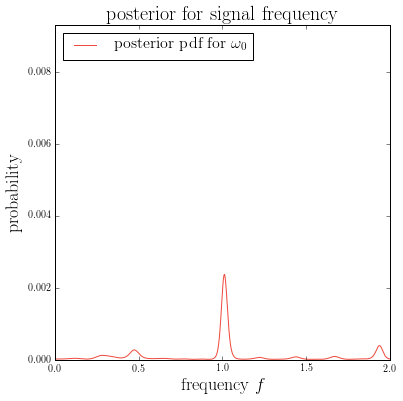

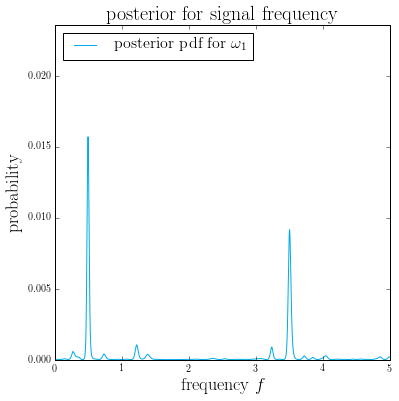

In [4]:
# Signal 0
fig=plt.figure()

plt.plot([omega/(2*pi) for omega in omegas_0], ps_0, label=r'posterior pdf for $\omega_{0}$', color=c_0)
#plt.plot([omega_0, omega_0], [0, 1], ls='--', lw=3, label=r'true $\omega_{0}$', color=c_0)

plt.xlim(0, 2*f_0)
plt.ylim(0, 1.5*max(ps_0))

plt.legend(loc='upper left', fontsize=legend_size)

fig.set_size_inches(10,8)
plt.title(r'posterior for signal frequency', size=title_size)
plt.xlabel(r'frequency $f$', size=label_size)
plt.ylabel(r'probability', size=label_size)



fig.set_size_inches(6,6)

plt.show()

# Signal 1
fig=plt.figure()
plt.plot([omega/(2*pi) for omega in omegas_1], ps_1, label=r'posterior pdf for $\omega_{1}$', color=c_1)
#plt.plot([omega_1, omega_1], [0, 1], ls='--', lw=3, label=r'true $\omega_{1}$', color=c_1)

plt.xlim(0, 10*f_1)
plt.ylim(0, 1.5*max(ps_1))

plt.legend(loc='upper left', fontsize=legend_size)

fig.set_size_inches(10,8)
plt.title(r'posterior for signal frequency', size=title_size)
plt.xlabel(r'frequency $f$', size=label_size)
plt.ylabel(r'probability', size=label_size)



fig.set_size_inches(6,6)

plt.show()

#### Calculate the maximum a posteriori probabilities for amplitudes $a$ and $b$, and their uncertainties
- MAP estimates of $a$ and $b$: Solve
$$\frac{dp\left(\omega, a, b, \sigma |\{t,y\}\right)}{da}\Big|_{a=a_{0}}=0,\, \frac{dp\left(\omega, a, b, \sigma |\{t,y\}\right)}{db}\Big|_{b=b_{0}}=0$$

    - Answer: 
$$a_{0}=\frac{2I\left(\omega\right)}{N},\, b_{0}=\frac{2R\left(\omega\right)}{N}$$


- MAP uncertainties:
$$\sigma_{a}, \sigma_{b} = \frac{d^{2}p\left(\omega, a, b, \sigma |\{t,y\}\right)}{da^{2}}\Big|_{a=a_{0}},\, \frac{d^{2}p\left(\omega, a, b, \sigma |\{t,y\}\right)}{db^{2}}\Big|_{b=b_{0}}$$

    - Answer: 
$$\sigma_{a}=\sigma_{b}=\sigma\sqrt{2/N}$$

In [5]:
as_0=[2*I(omega, ts_0, ys_measured_0)/N_0 for omega in omegas_0]
bs_0=[2*R(omega, ts_0, ys_measured_0)/N_0 for omega in omegas_0]

as_1=[2*I(omega, ts_1, ys_measured_1)/N_1 for omega in omegas_1]
bs_1=[2*R(omega, ts_1, ys_measured_1)/N_1 for omega in omegas_1]

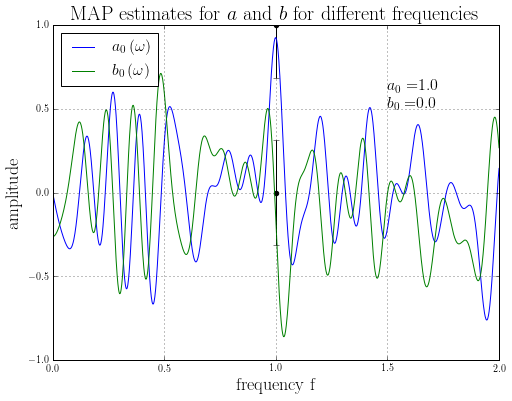

In [6]:
fig=plt.figure()

plt.plot([omega/(2*pi) for omega in omegas_0], as_0, label=r'$a_0\left(\omega\right)$')
plt.plot([omega/(2*pi) for omega in omegas_0], bs_0, label=r'$b_0\left(\omega\right)$')
plt.errorbar(f_0, a_0, xerr=0, yerr=sigma_0*(2./N_0)**0.5, color=(0,0,0))
plt.errorbar(f_0, b_0, xerr=0, yerr=sigma_0*(2./N_0)**0.5, color=(0,0,0))
plt.scatter([f_0,f_0],[a_0,b_0], color=(0,0,0))

plt.text(1.5*f_0, A_0/2, r'$a_{0}=$'+str(a_0)+'\n$b_{0}=$'+str(b_0), size=legend_size)
plt.xlim(0,2*f_0)
plt.ylim(-A_0, A_0)

plt.grid()

plt.title('MAP estimates for $a$ and $b$ for different frequencies', size=title_size)
plt.xlabel('frequency f', size=label_size)
plt.ylabel('amplitude', size=label_size)
plt.legend(loc='upper left', fontsize=legend_size)

fig.set_size_inches(8,6)

plt.show()

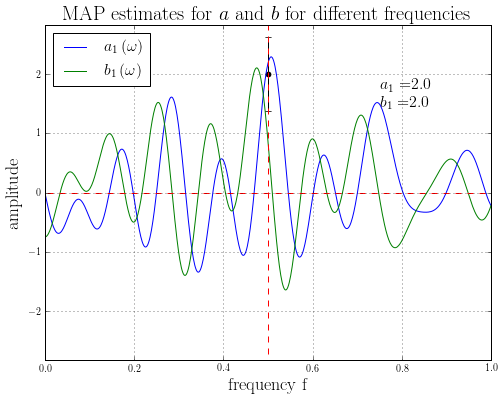

In [7]:
fig=plt.figure()

plt.plot([omega/(2*pi) for omega in omegas_1], as_1, label=r'$a_1\left(\omega\right)$')
plt.plot([omega/(2*pi) for omega in omegas_1], bs_1, label=r'$b_1\left(\omega\right)$')
plt.scatter([f_1,f_1],[a_1,b_1], color=(0,0,0))
plt.errorbar(f_1, a_1, xerr=0, yerr=sigma_1*(2./N_1)**0.5, color=(0,0,0))
plt.errorbar(f_1, b_1, xerr=0, yerr=sigma_1*(2./N_1)**0.5, color=(0,0,0))

plt.plot([f_1,f_1],[-10,10], ls='--', color=(1,0,0))
plt.plot([-0.8,1.2],[0,0], ls='--', color=(1,0,0))
plt.text(1.5*f_1, A_1/2, r'$a_{1}=$'+str(a_1)+'\n$b_{1}=$'+str(b_1), size=legend_size)
plt.xlim(0,2*f_1)
plt.ylim(-A_1, A_1)

plt.grid()

plt.title('MAP estimates for $a$ and $b$ for different frequencies', size=title_size)
plt.xlabel('frequency f', size=label_size)
plt.ylabel('amplitude', size=label_size)
plt.legend(loc='upper left', fontsize=legend_size)

fig.set_size_inches(8,6)

plt.show()

#### Still need to calculate the best value of $\omega$ from the data, and determine whether the periodic variability is statistically significant
- Calculate $\chi^{2}\left(\omega\right)$ for a fit with the MAP estimates of $a_{0}\left(\omega\right)$ and $b_{0}\left(\omega\right)$
$$\chi^{2}\left(\omega\right)\equiv\frac{1}{\sigma^{2}}\sum_{j=1}^{N}\left[y_{j}-y\left(t_{j}\right)\right]^{2}=\frac{1}{\sigma^{2}}\sum_{j=1}^{N}\left[y_{j}-a_{0}\sin\left(\omega t_{j}\right)-b_{0}\cos\left(\omega t_{j}\right)\right]^{2}$$
$$\chi^{2}\left(\omega\right)=\chi_{0}^{2}\left[1-\frac{2}{N V}P\left(\omega\right)\right]$$
- $\chi_{0}^{2}$ is for a model of a constant signal plus noise
- Reduction in $\chi^{2}$ for the harmonic model relative to constant model is
$$\frac{\chi^{2}\left(\omega\right)}{\chi_{0}^{2}}=1-P_{LS}\left(\omega\right),\, P_{LS}\left(\omega\right)=\frac{2}{N V}P\left(\omega\right)$$
- $P_{LS}\left(\omega\right)$ is the **Lomb-Scargle periodogram** (periodogram normalized by total signal power)
- $\chi^{2}$ is minimized when $P_{LS}\left(\omega\right)=1)$, or equivalently, when $\sim P\left(\omega\right)=\frac{1}{N}\left[I^{2}\left(\omega\right)+R^{2}\left(\omega\right)\right]=\frac{1}{N}\sum_{j=1}^{N}y_{j}^{2}$


#### Compare pure noise model with single harmonic model using BIC criterion
$$\Delta BIC=\chi_{0}^{2}-\chi^{2}\left(\omega_{0}\right)-\left(k_{0}-k_{\omega}\right)ln N$$

- ...
- Minimum ratio of signal/noise amplitudes to detect periodicity for difference of 10 threshold:
$$\frac{A}{\sigma}_{BIC}>\left(\frac{20+6lnN}{N}\right)^{1/2}$$
- A is total signal amplitude, $A=\left(a^{2}+b^{2}\right)^{1/2}$

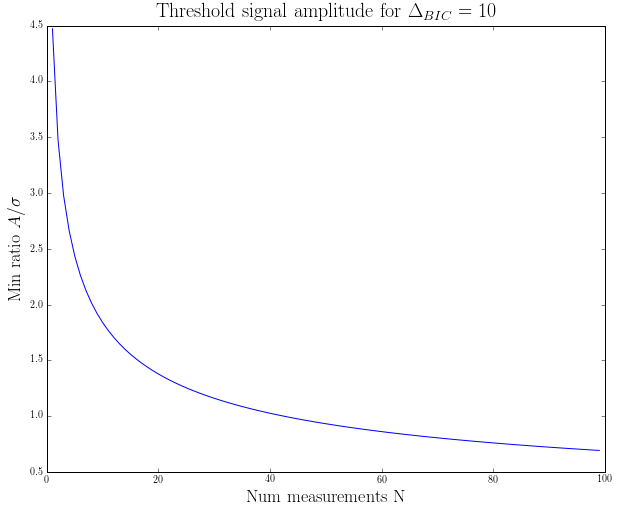

In [8]:
Ns=[i for i in range(1,100)]
ratios=[((20+6*log(N))/N)**0.5 for N in Ns]


fig=plt.figure()

plt.plot(Ns, ratios)

plt.title(r'Threshold signal amplitude for $\Delta_{BIC}=10$', size=title_size)
plt.xlabel(r'Num measurements N', size=label_size)
plt.ylabel(r'Min ratio $A/\sigma$', size=label_size)

fig.set_size_inches(10,8)
plt.show()

### 10.3.2. The Lomb-Scargle Periodogram


- dFT cannot be used when data are unevenly sampled
- Lomb-Scargle (LS) periodogram is method to search for periodicity in unevenly sampled time series data
- Normalized LS periodogram with heteroscedastic errors defined as
$$P_{LS}\left(\omega\right)=\frac{1}{V}\left[\frac{R^{2}\left(\omega\right)}{C\left(\omega\right)}+\frac{I^{2}\left(\omega\right)}{S\left(\omega\right)}\right]$$

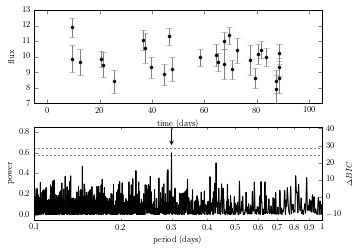

In [9]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate Data
np.random.seed(0)
N = 30
P = 0.3

t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
y = 10 + np.sin(2 * np.pi * t / P)
dy = 0.5 + 0.5 * np.random.random(N)
y_obs = np.random.normal(y, dy)

#------------------------------------------------------------
# Compute periodogram
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period
PS = lomb_scargle(t, y_obs, dy, omega, generalized=True)

#------------------------------------------------------------
# Get significance via bootstrap
D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True,
                           N_bootstraps=1000, random_state=0)
sig1, sig5 = np.percentile(D, [99, 95])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(5, 3.75))
fig.subplots_adjust(left=0.1, right=0.9, hspace=0.25)

# First panel: the data
ax = fig.add_subplot(211)
ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
ax.set_xlabel('time (days)')
ax.set_ylabel('flux')
ax.set_xlim(-5, 105)

# Second panel: the periodogram & significance levels
ax1 = fig.add_subplot(212, xscale='log')
ax1.plot(period, PS, '-', c='black', lw=1, zorder=1)
ax1.plot([period[0], period[-1]], [sig1, sig1], ':', c='black')
ax1.plot([period[0], period[-1]], [sig5, sig5], ':', c='black')

ax1.annotate("", (0.3, 0.65), (0.3, 0.85), ha='center',
             arrowprops=dict(arrowstyle='->'))

ax1.set_xlim(period[0], period[-1])
ax1.set_ylim(-0.05, 0.85)

ax1.set_xlabel(r'period (days)')
ax1.set_ylabel('power')

# Twin axis: label BIC on the right side
ax2 = ax1.twinx()
ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
ax2.set_ylabel(r'$\Delta BIC$')

ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
ax1.xaxis.set_major_locator(plt.LogLocator(10))
ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

plt.show()

###10.3.3 Truncated Fourier Series Model
- What to do if signal has higher harmonics?
- Consider a multiple harmonic model:
$$y\left(t\right)=b_{0}+\sum_{m=1}^{M}a_{m}\sin\left(m\omega t\right)+b_{m}\cos\left(m\omega t\right)$$

$$P_{M}\left(\omega\right)=\frac{2}{V}\sum_{m=1}^{M}\left[R^{2}_{m}\left(\omega\right)+I_{m}^{2}\left(\omega\right)\right]$$
$$I_{m}\left(\omega\right)=\sum_{j=1}^{N}w_{j}y_{j}sin\left(m\omega t_{j}\right),\, R_{m}\left(\omega\right)=\sum_{j=1}^{N}w_{j}y_{j}\cos\left(m \omega t_{j}\right)$$

$$a_{m}=\frac{2I_{m}\left(\omega\right)}{N},\, b_{m}=\frac{2R_{m}\left(\omega\right)}{N}$$

@pickle_results: using precomputed results from 'LINEAR_LS.pkl'
 - omega_0 = 17.21695506
 - omega_0 = 51.10600808
 - omega_0 = 10.20062676
 - omega_0 = 45.55493503
 - omega_0 = 58.44512277
 - omega_0 = 10.82722772


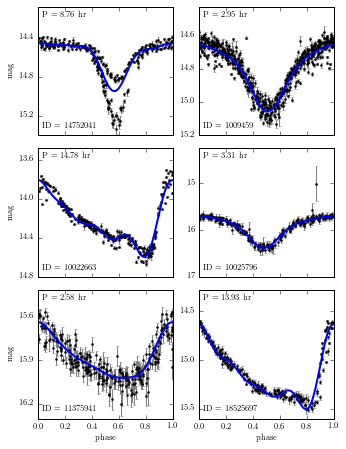

In [10]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.decorators import pickle_results
from astroML.time_series import search_frequencies, lomb_scargle, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Load the dataset
data = fetch_LINEAR_sample()
ids = [14752041, 1009459, 10022663, 10025796, 11375941, 18525697]


#------------------------------------------------------------
# Compute the best frequencies
@pickle_results('LINEAR_LS.pkl')
def compute_best_frequencies(ids, n_eval=10000, n_retry=5, generalized=True):
    results = {}
    for i in ids:
        t, y, dy = data[i].T
        print " - computing power for %i (%i points)" % (i, len(t))
        kwargs = dict(generalized=generalized)
        omega, power = search_frequencies(t, y, dy, n_eval=n_eval,
                                          n_retry=n_retry,
                                          LS_kwargs=kwargs)
        results[i] = [omega, power]

    return results

results = compute_best_frequencies(ids, n_eval=10000, n_retry=5)

#------------------------------------------------------------
# Plot the phased light-curves
fig = plt.figure(figsize=(5, 6.5))
fig.subplots_adjust(hspace=0.1, bottom=0.06, top=0.94, left=0.12, right=0.94)

for i in range(6):
    # get the data and best-fit angular frequency
    t, y, dy = data[ids[i]].T
    omega, power = results[ids[i]]
    omega_best = omega[np.argmax(power)]
    print " - omega_0 = %.10g" % omega_best

    # do a fit to the first 4 Fourier components
    mtf = MultiTermFit(omega_best, 4)
    mtf.fit(t, y, dy)
    phase_fit, y_fit, phased_t = mtf.predict(1000, return_phased_times=True)

    # plot the phased data and best-fit curves
    ax = fig.add_subplot(321 + i)
    ax.errorbar(phased_t, y, dy, fmt='.k', ecolor='gray',
                lw=1, ms=4, capsize=1.5)
    ax.plot(phase_fit, y_fit, '-b', lw=2)

    ax.set_xlim(0, 1)
    ax.set_ylim(plt.ylim()[::-1])
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))

    ax.text(0.03, 0.04, "ID = %i" % ids[i], ha='left', va='bottom',
            transform=ax.transAxes)
    ax.text(0.03, 0.96, "P = %.2f hr" % (2 * np.pi / omega_best * 24.),
            ha='left', va='top',
            transform=ax.transAxes)

    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))

    if i < 4:
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    if i % 2 == 0:
        ax.set_ylabel('mag')

    if i in (4, 5):
        ax.set_xlabel('phase')

plt.show()

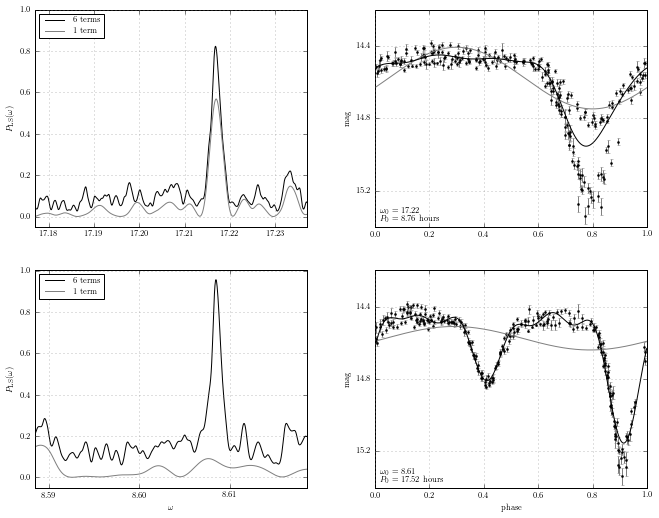

In [11]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import multiterm_periodogram, MultiTermFit
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get data
data = fetch_LINEAR_sample()
t, y, dy = data[14752041].T

#------------------------------------------------------------
# Do a single-term and multi-term fit around the peak
omega0 = 17.217
nterms_fit = 6

# hack to get better phases: this doesn't change results,
#  except for how the phase plots are displayed
t -= 0.4 * np.pi / omega0

width = 0.03
omega = np.linspace(omega0 - width - 0.01, omega0 + width - 0.01, 1000)

#------------------------------------------------------------
# Compute periodograms and best-fit solutions
#  factor gives the factor that we're dividing the fundamental frequency by
factors = [1, 2]
nterms = [1, 6]

# Compute PSDs for factors & nterms
PSDs = dict()
for f in factors:
    for n in nterms:
        PSDs[(f, n)] = multiterm_periodogram(t, y, dy, omega / f, n)

# Compute the best-fit omega from the 6-term fit
omega_best = dict()
for f in factors:
    omegaf = omega / f
    PSDf = PSDs[(f, 6)]
    omega_best[f] = omegaf[np.argmax(PSDf)]

# Compute the best-fit solution based on the fundamental frequency
best_fit = dict()
for f in factors:
    for n in nterms:
        mtf = MultiTermFit(omega_best[f], n)
        mtf.fit(t, y, dy)
        phase_best, y_best = mtf.predict(1000, adjust_offset=False)

        best_fit[(f, n)] = (phase_best, y_best)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25,
                    bottom=0.12, top=0.95, hspace=0.2)

for i, f in enumerate(factors):
    P_best = 2 * np.pi / omega_best[f]
    phase_best = (t / P_best) % 1

    # first column: plot the PSD
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.plot(omega / f, PSDs[(f, 6)], '-', c='black', label='6 terms')
    ax1.plot(omega / f, PSDs[(f, 1)], '-', c='gray', label='1 term')
    ax1.grid(color='gray')
    ax1.legend(loc=2)

    ax1.axis('tight')
    ax1.set_ylim(-0.05, 1.001)
    ax1.xaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

    # second column: plot the phased data & fit
    ax2 = fig.add_subplot(222 + 2 * i)
    ax2.errorbar(phase_best, y, dy, fmt='.k', ms=4, ecolor='gray', lw=1,
                 capsize=1.5)
    ax2.plot(best_fit[(f, 1)][0], best_fit[(f, 1)][1], '-', c='gray')
    ax2.plot(best_fit[(f, 6)][0], best_fit[(f, 6)][1], '-', c='black')

    ax2.text(0.02, 0.02, (r"$\omega_0 = %.2f$" % omega_best[f] + "\n"
                          + r"$P_0 = %.2f\ {\rm hours}$" % (24 * P_best)),
             ha='left', va='bottom', transform=ax2.transAxes)

    ax2.grid(color='gray')
    ax2.set_xlim(0, 1)
    ax2.set_ylim(plt.ylim()[::-1])
    ax2.yaxis.set_major_locator(plt.MultipleLocator(0.4))

    # label both axes
    ax1.set_ylabel(r'$P_{\rm LS}(\omega)$')
    ax2.set_ylabel(r'${\rm mag}$')
    if i == 1:
        ax1.set_xlabel(r'$\omega$')
        ax2.set_xlabel(r'${\rm phase}$')

plt.show()

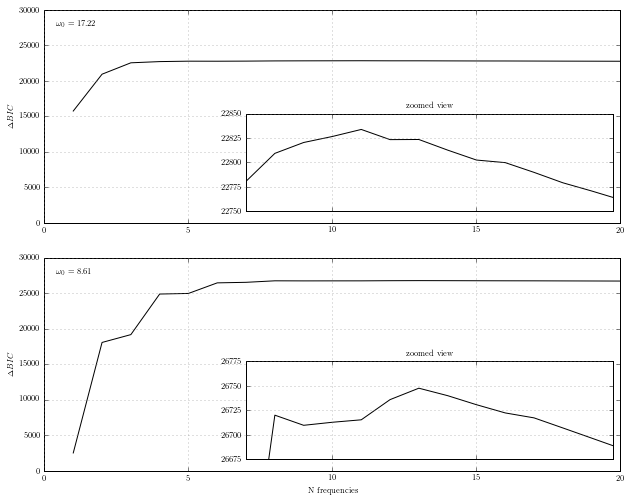

In [12]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from astroML.time_series import multiterm_periodogram, lomb_scargle_BIC
from astroML.datasets import fetch_LINEAR_sample

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Fetch the data
data = fetch_LINEAR_sample()

t, y, dy = data[14752041].T
omega0 = 17.217

# focus only on the region with the peak
omega1 = np.linspace(17.213, 17.220, 100)
omega2 = 0.5 * omega1

#------------------------------------------------------------
# Compute the delta BIC
terms = np.arange(1, 21)
BIC_max = np.zeros((2, len(terms)))

for i, omega in enumerate([omega1, omega2]):
    for j in range(len(terms)):
        P = multiterm_periodogram(t, y, dy, omega, terms[j])
        BIC = lomb_scargle_BIC(P, y, dy, n_harmonics=terms[j])
        BIC_max[i, j] = BIC.max()

#----------------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 8))

ax = [fig.add_axes((0.15, 0.53, 0.8, 0.37)),
      fig.add_axes((0.15, 0.1, 0.8, 0.37))]
ax_inset = [fig.add_axes((0.15 + 7 * 0.04, 0.55, 0.79 - 7 * 0.04, 0.17)),
            fig.add_axes((0.15 + 7 * 0.04, 0.12, 0.79 - 7 * 0.04, 0.17))]
ylims = [(22750, 22850),
         (26675, 26775)]
omega0 = [17.22, 8.61]

for i in range(2):
    # Plot full panel
    ax[i].plot(terms, BIC_max[i], '-k')
    ax[i].set_xlim(0, 20)
    ax[i].set_ylim(0, 30000)
    ax[i].text(0.02, 0.95, r"$\omega_0 = %.2f$" % omega0[i],
               ha='left', va='top', transform=ax[i].transAxes)

    ax[i].set_ylabel(r'$\Delta BIC$')
    if i == 1:
        ax[i].set_xlabel('N frequencies')
    ax[i].grid(color='gray')

    # plot inset
    ax_inset[i].plot(terms, BIC_max[i], '-k')
    ax_inset[i].xaxis.set_major_locator(plt.MultipleLocator(5))
    ax_inset[i].xaxis.set_major_formatter(plt.NullFormatter())
    ax_inset[i].yaxis.set_major_locator(plt.MultipleLocator(25))
    ax_inset[i].yaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    ax_inset[i].set_xlim(7, 19.75)
    ax_inset[i].set_ylim(ylims[i])
    ax_inset[i].set_title('zoomed view')
    ax_inset[i].grid(color='gray')

plt.show()

### 10.3.4: Classification of Periodic Light Curves
- The fundamental frequency determined e.g. by a light curve can act as a new feature in classification problems

#### Gaussian mixture clustering

@pickle_results: using precomputed results from 'LINEAR_clustering.pkl'
number of components: 11
\begin{tabular}{|l|lllllll|}
   \hline
   & $u-g$    & $g-i$    & $i-K$    & $J-K$    & $\log(P)$    & amplitude    & skew \\
   \hline
   1   & $1.15 \pm 0.08$   & $0.30 \pm 0.06$   & $1.14 \pm 0.20$   & $0.30 \pm 0.15$   & $-0.24 \pm 0.06$   & $0.67 \pm 0.18$   & $-0.18 \pm 1.07$  \\
   2   & $1.18 \pm 0.11$   & $-0.00 \pm 0.12$   & $0.93 \pm 0.35$   & $0.24 \pm 0.16$   & $-0.48 \pm 0.05$   & $0.43 \pm 0.10$   & $0.34 \pm 1.06$  \\
   3   & $1.47 \pm 0.34$   & $0.76 \pm 0.25$   & $1.52 \pm 0.36$   & $0.50 \pm 0.14$   & $-0.53 \pm 0.06$   & $0.50 \pm 0.14$   & $0.87 \pm 1.04$  \\
   4   & $1.19 \pm 0.07$   & $0.00 \pm 0.13$   & $0.88 \pm 0.25$   & $0.30 \pm 0.17$   & $-0.24 \pm 0.06$   & $0.70 \pm 0.19$   & $-0.25 \pm 0.86$  \\
   5   & $1.08 \pm 0.11$   & $-0.03 \pm 0.12$   & $0.78 \pm 0.17$   & $0.19 \pm 0.17$   & $-1.20 \pm 0.08$   & $-3.43 \pm 19.31$   & $0.17 \pm 1.85$  \\
   6   & $1

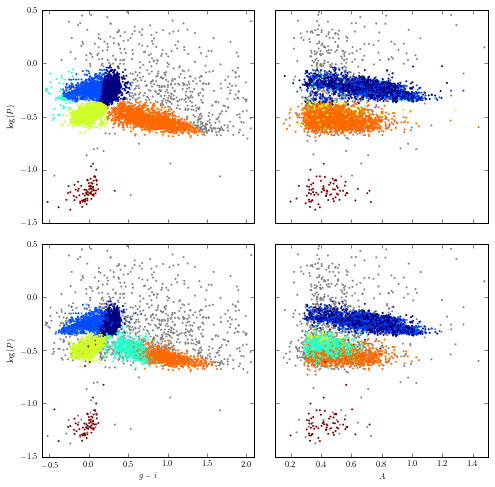

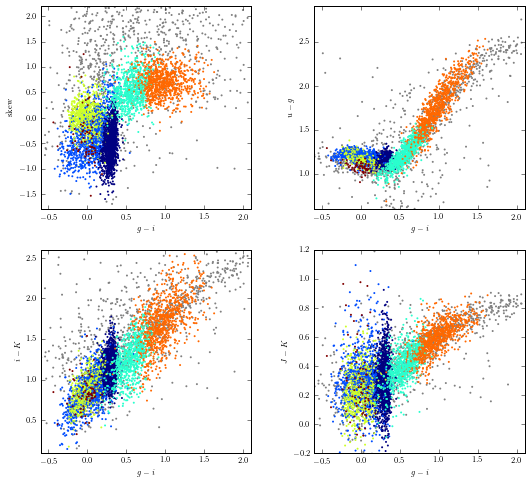

In [13]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from sklearn.mixture import GMM

from astroML.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_geneva

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Get the Geneva periods data
data = fetch_LINEAR_geneva()

#----------------------------------------------------------------------
# compute Gaussian Mixture models

filetemplate = 'gmm_res_%i_%i.pkl'
attributes = [('gi', 'logP'),
              ('ug', 'gi', 'iK', 'JK', 'logP', 'amp', 'skew')]
components = np.arange(1, 21)

#------------------------------------------------------------
# Create attribute arrays
Xarrays = []
for attr in attributes:
    Xarrays.append(np.vstack([data[a] for a in attr]).T)


#------------------------------------------------------------
# Compute the results (and save to pickle file)
@pickle_results('LINEAR_clustering.pkl')
def compute_GMM_results(components, attributes):
    clfs = []

    for attr, X in zip(attributes, Xarrays):
        clfs_i = []

        for comp in components:
            print "  - %i component fit" % comp
            clf = GMM(comp, covariance_type='full',
                      random_state=0, n_iter=500)
            clf.fit(X)
            clfs_i.append(clf)

            if not clf.converged_:
                print "           NOT CONVERGED!"

        clfs.append(clfs_i)
    return clfs

clfs = compute_GMM_results(components, attributes)

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

class_labels = []

for i in range(2):
    # Grab the best classifier, based on the BIC
    X = Xarrays[i]
    BIC = [c.bic(X) for c in clfs[i]]
    i_best = np.argmin(BIC)

    print "number of components:", components[i_best]

    clf = clfs[i][i_best]
    n_components = clf.n_components

    # Predict the cluster labels with the classifier
    c = clf.predict(X)
    classes = np.unique(c)

    class_labels.append(c)

    # sort the cluster by normalized density of points
    counts = np.sum(c == classes[:, None], 1)
    size = np.array([np.linalg.det(C) for C in clf.covars_])
    weights = clf.weights_
    density = counts / size

    # Clusters with very few points are less interesting:
    # set their density to zero so they'll go to the end of the list
    density[counts < 5] = 0
    isort = np.argsort(density)[::-1]

    # find statistics of the top 10 clusters
    Nclusters = 6

    means = []
    stdevs = []
    counts = []

    names = [name for name in data.dtype.names[2:] if name != 'LINEARobjectID']
    labels = ['$u-g$', '$g-i$', '$i-K$', '$J-K$',
              r'$\log(P)$', 'amplitude', 'skew',
              'kurtosis', 'median mag', r'$N_{\rm obs}$', 'Visual Class']
    
    assert len(names) == len(labels)
    
    i_logP = names.index('logP')

    for j in range(Nclusters):
        flag = (c == isort[j])
        counts.append(np.sum(flag))
        means.append([np.mean(data[n][flag]) for n in names])
        stdevs.append([data[n][flag].std() for n in names])

    counts = np.array(counts)
    means = np.array(means)
    stdevs = np.array(stdevs)

    # define colors based on median of logP
    j_ordered = np.argsort(-means[:, i_logP])

    # tweak colors by hand
    if i == 1:
        j_ordered[3], j_ordered[2] = j_ordered[2], j_ordered[3]

    color = np.zeros(c.shape)
    for j in range(Nclusters):
        flag = (c == isort[j_ordered[j]])
        color[flag] = j + 1

    # separate into foureground and background
    back = (color == 0)
    fore = ~back

    # Plot the resulting clusters
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.scatter(data['gi'][back], data['logP'][back],
                c='gray', edgecolors='none', s=4, linewidths=0)
    ax1.scatter(data['gi'][fore], data['logP'][fore],
                c=color[fore], edgecolors='none',  s=4, linewidths=0)

    ax1.set_ylabel(r'$\log(P)$')

    ax2 = plt.subplot(222 + 2 * i)
    ax2.scatter(data['amp'][back], data['logP'][back],
                c='gray', edgecolors='none', s=4, linewidths=0)
    ax2.scatter(data['amp'][fore], data['logP'][fore],
                c=color[fore], edgecolors='none', s=4, linewidths=0)

    #------------------------------
    # set axis limits
    ax1.set_xlim(-0.6, 2.1)
    ax2.set_xlim(0.1, 1.5)
    ax1.set_ylim(-1.5, 0.5)
    ax2.set_ylim(-1.5, 0.5)

    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    if i == 0:
        ax1.xaxis.set_major_formatter(plt.NullFormatter())
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_xlabel(r'$g-i$')
        ax2.set_xlabel(r'$A$')


    #------------------------------
    # print table of means and medians directly to LaTeX format
    print r"\begin{tabular}{|l|lllllll|}"
    print r"   \hline"
    for j in range(7):
        print '   &', labels[j],
    print r"\\"
    print r"   \hline"

    for j in range(Nclusters):
        print "   %i " % (j + 1),
        for k in range(7):
            print " & $%.2f \pm %.2f$ " % (means[j, k], stdevs[j, k]),
        print r"\\"

    print r"\hline"
    print r"\end{tabular}"

#------------------------------------------------------------
# Second figure
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3)

attrs = ['skew', 'ug', 'iK', 'JK']
labels = ['skew', '$u-g$', '$i-K$', '$J-K$']
ylims = [(-1.8, 2.2), (0.6, 2.9), (0.1, 2.6), (-0.2, 1.2)]

for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.scatter(data['gi'][back], data[attrs[i]][back],
               c='gray', edgecolors='none', s=4, linewidths=0)
    ax.scatter(data['gi'][fore], data[attrs[i]][fore],
               c=color[fore], edgecolors='none', s=4, linewidths=0)
    ax.set_xlabel('$g-i$')
    ax.set_ylabel(labels[i])

    ax.set_xlim(-0.6, 2.1)
    ax.set_ylim(ylims[i])

#------------------------------------------------------------
# Save the results
#
# run the script as
#
#   >$ python fig_LINEAR_clustering.py --save
#
# to output the data file showing the cluster labels of each point
import sys
if len(sys.argv) > 1 and sys.argv[1] == '--save':
    filename = 'cluster_labels.dat'

    print "Saving cluster labels to %s" % filename

    from astroML.datasets.LINEAR_sample import ARCHIVE_DTYPE
    new_data = np.zeros(len(data),
                        dtype=(ARCHIVE_DTYPE + [('2D_cluster_ID', 'i4'),
                                                ('7D_cluster_ID', 'i4')]))

    for name in data.dtype.names:
        new_data[name] = data[name]
    new_data['2D_cluster_ID'] = class_labels[0]
    new_data['7D_cluster_ID'] = class_labels[1]

    fmt = ('%.6f   %.6f   %.3f   %.3f   %.3f   %.3f   %.7f   %.3f   %.3f   '
           '%.3f    %.2f     %i     %i      %s          %i              %i\n')


    F = open(filename, 'w')
    F.write('#    ra           dec       ug      gi      iK      JK     '
            'logP       Ampl    skew      kurt    magMed    nObs  LCtype  '
            'LINEARobjectID  2D_cluster_ID   7D_cluster_ID\n')
    for line in new_data:
        F.write(fmt % tuple(line[col] for col in line.dtype.names))
    F.close()

plt.show()

#### Support vector machine classification

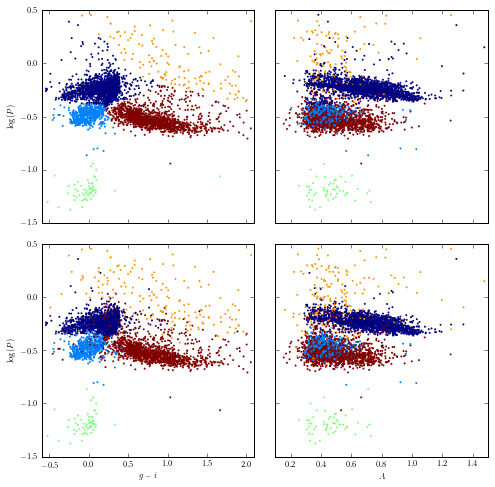

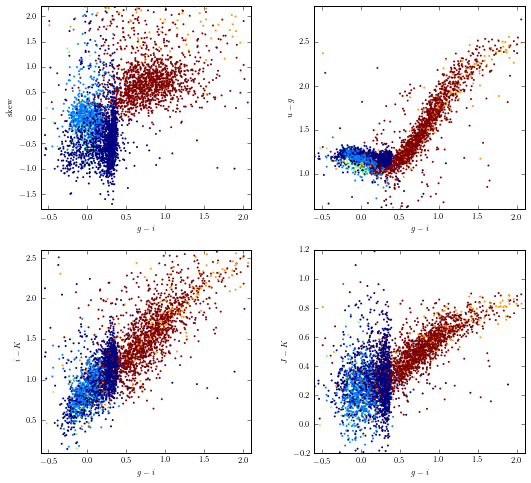

In [14]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from astroML.decorators import pickle_results
from astroML.datasets import fetch_LINEAR_geneva

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

data = fetch_LINEAR_geneva()

attributes = [('gi', 'logP'),
              ('gi', 'logP', 'ug', 'iK', 'JK', 'amp', 'skew')]
labels = ['$u-g$', '$g-i$', '$i-K$', '$J-K$',
          r'$\log(P)$', 'amplitude', 'skew']
cls = 'LCtype'
Ntrain = 3000

#------------------------------------------------------------
# Create attribute arrays
X = []
y = []

for attr in attributes:
    X.append(np.vstack([data[a] for a in attr]).T)
    LCtype = data[cls].copy()

    # there is no #3.  For a better color scheme in plots,
    # we'll set 6->3
    LCtype[LCtype == 6] = 3
    y.append(LCtype)


#@pickle_results('LINEAR_SVM.pkl')
def compute_SVM_results(i_train, i_test):
    classifiers = []
    predictions = []
    Xtests = []
    ytests = []
    Xtrains = []
    ytrains = []

    for i in range(len(attributes)):
        Xtrain = X[i][i_train]
        Xtest = X[i][i_test]
        ytrain = y[i][i_train]
        ytest = y[i][i_test]

        clf = SVC(kernel='linear', class_weight=None)
        clf.fit(Xtrain, ytrain)
        y_pred = clf.predict(Xtest)

        classifiers.append(clf)
        predictions.append(y_pred)

    return classifiers, predictions


i = np.arange(len(data))
i_train, i_test = train_test_split(i, random_state=0, train_size=2000)
clfs, ypred = compute_SVM_results(i_train, i_test)


#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

class_labels = []

for i in range(2):
    Xtest = X[i][i_test]
    ytest = y[i][i_test]
    amp = data['amp'][i_test]
    
    # Plot the resulting classifications
    ax1 = fig.add_subplot(221 + 2 * i)
    ax1.scatter(Xtest[:, 0], Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, linewidths=0)

    ax1.set_ylabel(r'$\log(P)$')

    ax2 = plt.subplot(222 + 2 * i)
    ax2.scatter(amp, Xtest[:, 1],
                c=ypred[i], edgecolors='none', s=4, lw=0)

    #------------------------------
    # set axis limits
    ax1.set_xlim(-0.6, 2.1)
    ax2.set_xlim(0.1, 1.5)
    ax1.set_ylim(-1.5, 0.5)
    ax2.set_ylim(-1.5, 0.5)

    ax2.yaxis.set_major_formatter(plt.NullFormatter())
    if i == 0:
        ax1.xaxis.set_major_formatter(plt.NullFormatter())
        ax2.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax1.set_xlabel(r'$g-i$')
        ax2.set_xlabel(r'$A$')

#------------------------------------------------------------
# Second figure
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.3)

attrs = ['skew', 'ug', 'iK', 'JK']
labels = ['skew', '$u-g$', '$i-K$', '$J-K$']
ylims = [(-1.8, 2.2), (0.6, 2.9), (0.1, 2.6), (-0.2, 1.2)]

for i in range(4):
    ax = fig.add_subplot(221 + i)
    ax.scatter(data['gi'][i_test], data[attrs[i]][i_test],
               c=ypred[1], edgecolors='none', s=4, lw=0)
    ax.set_xlabel('$g-i$')
    ax.set_ylabel(labels[i])

    ax.set_xlim(-0.6, 2.1)
    ax.set_ylim(ylims[i])

#------------------------------------------------------------
# Save the results
#
# run the script as
#
#   >$ python fig_LINEAR_clustering.py --save
#
# to output the data file showing the cluster labels of each point
import sys
if len(sys.argv) > 1 and sys.argv[1] == '--save':
    filename = 'cluster_labels_svm.dat'

    print "Saving cluster labels to %s" % filename

    from astroML.datasets.LINEAR_sample import ARCHIVE_DTYPE
    new_data = np.zeros(len(data),
                        dtype=(ARCHIVE_DTYPE + [('2D_cluster_ID', 'i4'),
                                                ('7D_cluster_ID', 'i4')]))
    
    # switch the labels back 3->6
    for i in range(2):
        ypred[i][ypred[i] == 3] = 6

    # need to put labels back in order
    class_labels = [-999 * np.ones(len(data)) for i in range(2)]
    for i in range(2):
        class_labels[i][i_test] = ypred[i]

    for name in data.dtype.names:
        new_data[name] = data[name]
    new_data['2D_cluster_ID'] = class_labels[0]
    new_data['7D_cluster_ID'] = class_labels[1]

    fmt = ('%.6f   %.6f   %.3f   %.3f   %.3f   %.3f   %.7f   %.3f   %.3f   '
           '%.3f    %.2f     %i     %i      %s          %i              %i\n')


    F = open(filename, 'w')
    F.write('#    ra           dec       ug      gi      iK      JK     '
            'logP       Ampl    skew      kurt    magMed    nObs  LCtype  '
            'LINEARobjectID  2D_cluster_ID   7D_cluster_ID\n')
    for line in new_data:
        F.write(fmt % tuple(line[col] for col in line.dtype.names))
    F.close()

plt.show()